In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns

import datetime

%matplotlib inline

In [2]:
#Set the start and end date
startdate = datetime.date(2021,8,7)
enddate = datetime.date(2021,11,6)

#generate week list
date_range = []
for week in pd.date_range(startdate, enddate, freq = '7D'):
    date_range.append(week.date().strftime("%Y-%m-%d"))
    

#format week list
data_week = []
for day in date_range:
    week_convert = day[2:4] + day[5:7] + day[-2:]
    data_week.append(week_convert)
    

def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt" 
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)

mta_import = get_data(data_week)


mta_import.shape
 

(2935816, 11)

In [3]:
#List of columns we can work with
mta_import.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [4]:
#Fix the column names
mta_import.columns = mta_import.columns.str.strip()
mta_import.columns = mta_import.columns.str.title()

mta_import.columns

Index(['C/A', 'Unit', 'Scp', 'Station', 'Linename', 'Division', 'Date', 'Time',
       'Desc', 'Entries', 'Exits'],
      dtype='object')

In [5]:
# Columns that will be useful for Analysis
mta_import['Turnstile'] = mta_import['C/A'] + '|' + mta_import['Unit'] + '|' + mta_import['Scp'] + '|' + mta_import['Station']
mta_import['Station_loc'] = mta_import['Station'] + ' ' + mta_import['Linename']

#To perform by Date Analysis
mta_import['DateNTime'] = pd.to_datetime(mta_import['Date'] + '-' + mta_import['Time'], format='%m/%d/%Y-%H:%M:%S')
mta_import['Day'] = mta_import['DateNTime'].dt.strftime('%a')
mta_import['Day#'] = mta_import['DateNTime'].dt.dayofweek
mta_import['DayType'] = mta_import["Day#"].apply(lambda x: "WeekDay" if x < 5 else "WeekEnd")

#To perform by Hour Analysis
mta_import['Hour'] = mta_import['DateNTime'].dt.hour

mta_import.dtypes

C/A                    object
Unit                   object
Scp                    object
Station                object
Linename               object
Division               object
Date                   object
Time                   object
Desc                   object
Entries                 int64
Exits                   int64
Turnstile              object
Station_loc            object
DateNTime      datetime64[ns]
Day                    object
Day#                    int64
DayType                object
Hour                    int64
dtype: object

## The duplicate records point to a "Recover Aud"
Since there are no documentation to validate these entries:
1. Delete any duplicate records by Turnstile, Station and DateNTime
2. Use records that have a "REGULAR" entry instead of "RECOVER AUD"

In [6]:
# Drop Duplicate records
mta_import.sort_values(['Turnstile', 'Station_loc', 'DateNTime'], 
                          inplace=True, ascending=False)

mta_import.drop_duplicates(subset=['Turnstile', 'Station_loc', 'DateNTime'], inplace=True)

In [7]:
original_data = mta_import.shape
original_data

(2935661, 18)

In [8]:
mta_regular = mta_import[mta_import['Desc'] == 'REGULAR']
only_regular = mta_regular.shape
only_regular

(2923003, 18)

In [9]:
diff = original_data[0] - only_regular[0]
print(f'The number of records dropped from the original data are: {diff}')

The number of records dropped from the original data are: 12658


## Now, let's calculate the cumilative differences

In [10]:
turnstile = ["C/A", "Unit", "Scp"]

sort_filter = ["C/A", "Unit", "Scp", "Date", "Time"]


#Using the filtered data containing only REGULAR records
mta_diffs = mta_regular.sort_values(sort_filter).reset_index()
mta_diffs_group = mta_diffs.groupby(turnstile)

mta_diffs["Entries_Diff"] = mta_diffs_group["Entries"].transform(pd.Series.diff)
mta_diffs["Exits_Diff"] = mta_diffs_group["Exits"].transform(pd.Series.diff)

print(mta_diffs.shape)
mta_diffs.head()


(2923003, 21)


,index,C/A,Unit,Scp,Station,Linename,Division,Date,Time,Desc,...,Exits,Turnstile,Station_loc,DateNTime,Day,Day#,DayType,Hour,Entries_Diff,Exits_Diff
0,0,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/31/2021,00:00:00,REGULAR,...,2603110,A002|R051|02-00-00|59 ST,59 ST NQR456W,2021-07-31 00:00:00,Sat,5,WeekEnd,0,NaN,NaN
1,1,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/31/2021,04:00:00,REGULAR,...,2603113,A002|R051|02-00-00|59 ST,59 ST NQR456W,2021-07-31 04:00:00,Sat,5,WeekEnd,4,11.0,3.0
2,2,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/31/2021,08:00:00,REGULAR,...,2603126,A002|R051|02-00-00|59 ST,59 ST NQR456W,2021-07-31 08:00:00,Sat,5,WeekEnd,8,5.0,13.0
3,3,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/31/2021,12:00:00,REGULAR,...,2603178,A002|R051|02-00-00|59 ST,59 ST NQR456W,2021-07-31 12:00:00,Sat,5,WeekEnd,12,38.0,52.0
4,4,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/31/2021,16:00:00,REGULAR,...,2603211,A002|R051|02-00-00|59 ST,59 ST NQR456W,2021-07-31 16:00:00,Sat,5,WeekEnd,16,122.0,33.0


In [11]:
# Drop  NaN
mta_diffs.dropna(subset=["Entries_Diff"], axis=0, inplace=True)
mta_diffs.head()

,index,C/A,Unit,Scp,Station,Linename,Division,Date,Time,Desc,...,Exits,Turnstile,Station_loc,DateNTime,Day,Day#,DayType,Hour,Entries_Diff,Exits_Diff
1,1,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/31/2021,04:00:00,REGULAR,...,2603113,A002|R051|02-00-00|59 ST,59 ST NQR456W,2021-07-31 04:00:00,Sat,5,WeekEnd,4,11.0,3.0
2,2,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/31/2021,08:00:00,REGULAR,...,2603126,A002|R051|02-00-00|59 ST,59 ST NQR456W,2021-07-31 08:00:00,Sat,5,WeekEnd,8,5.0,13.0
3,3,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/31/2021,12:00:00,REGULAR,...,2603178,A002|R051|02-00-00|59 ST,59 ST NQR456W,2021-07-31 12:00:00,Sat,5,WeekEnd,12,38.0,52.0
4,4,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/31/2021,16:00:00,REGULAR,...,2603211,A002|R051|02-00-00|59 ST,59 ST NQR456W,2021-07-31 16:00:00,Sat,5,WeekEnd,16,122.0,33.0
5,5,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/31/2021,20:00:00,REGULAR,...,2603241,A002|R051|02-00-00|59 ST,59 ST NQR456W,2021-07-31 20:00:00,Sat,5,WeekEnd,20,155.0,30.0


## Filter out the zero value records
- Due to no foot traffic during those times

In [12]:
noZeros = (mta_diffs[(mta_diffs['Entries_Diff'] != 0) 
                     & (mta_diffs['Exits_Diff'] != 0)  ])
print(noZeros.shape)
noZeros[['Entries_Diff', 'Exits_Diff']].describe()

(2374122, 21)


,Entries_Diff,Exits_Diff
count,2.374122e+06,2.374122e+06
mean,-3.706008e+02,-5.133468e+01
std,2.553169e+06,3.164043e+06
min,-1.560008e+09,-2.133741e+09
25%,1.300000e+01,1.700000e+01
50%,4.500000e+01,4.900000e+01
75%,1.110000e+02,1.210000e+02
max,1.970611e+09,2.133741e+09


In [13]:
(noZeros[(noZeros['Entries_Diff'] == 0) 
                     & (noZeros['Exits_Diff'] == 0)  ])

,index,C/A,Unit,Scp,Station,Linename,Division,Date,Time,Desc,...,Exits,Turnstile,Station_loc,DateNTime,Day,Day#,DayType,Hour,Entries_Diff,Exits_Diff


## Convert negative values to positive then look into outliers

In [14]:
noZerosNoNegatives = noZeros.copy()

In [15]:
noZerosNoNegatives.shape

(2374122, 21)

In [16]:
def remove_neg(givenDF):
    if givenDF['Entries_Diff'] < 0:
        return givenDF['Entries_Diff'] * -1
    else:
        return givenDF['Entries_Diff']

noZerosNoNegatives['Entries_Diff'] = noZerosNoNegatives.apply(remove_neg,axis=1)
noZerosNoNegatives.sort_values('Entries_Diff').head()

,index,C/A,Unit,Scp,Station,Linename,Division,Date,Time,Desc,...,Exits,Turnstile,Station_loc,DateNTime,Day,Day#,DayType,Hour,Entries_Diff,Exits_Diff
586178,42864,J030,R005,00-00-02,85 ST-FOREST PK,J,BMT,10/04/2021,04:00:00,REGULAR,...,391993,J030|R005|00-00-02|85 ST-FOREST PK,85 ST-FOREST PK J,2021-10-04 04:00:00,Mon,0,WeekDay,4,1.0,6.0
1837950,132039,R107,R305,00-00-02,WTC-CORTLANDT,1,IRT,08/21/2021,09:00:00,REGULAR,...,60631,R107|R305|00-00-02|WTC-CORTLANDT,WTC-CORTLANDT 1,2021-08-21 09:00:00,Sat,5,WeekEnd,9,1.0,3.0
2081057,149520,R182,R035,00-03-01,168 ST,1AC,IRT,10/11/2021,04:00:00,REGULAR,...,550152,R182|R035|00-03-01|168 ST,168 ST 1AC,2021-10-11 04:00:00,Mon,0,WeekDay,4,1.0,31.0
820452,58944,N078,R175,01-03-03,14 ST,ACEL,IND,08/19/2021,05:00:00,REGULAR,...,745621,N078|R175|01-03-03|14 ST,14 ST ACEL,2021-08-19 05:00:00,Thu,3,WeekDay,5,1.0,16.0
1248062,89655,N334B,R341,00-03-00,75 AV,EF,IND,08/05/2021,20:00:00,REGULAR,...,160789,N334B|R341|00-03-00|75 AV,75 AV EF,2021-08-05 20:00:00,Thu,3,WeekDay,20,1.0,15.0


In [17]:
def remove_neg(givenDF):
    if givenDF['Exits_Diff'] < 0:
        return givenDF['Exits_Diff'] * -1
    else:
        return givenDF['Exits_Diff']

noZerosNoNegatives['Exits_Diff'] = noZerosNoNegatives.apply(remove_neg,axis=1)
noZerosNoNegatives.sort_values('Exits_Diff').head()

,index,C/A,Unit,Scp,Station,Linename,Division,Date,Time,Desc,...,Exits,Turnstile,Station_loc,DateNTime,Day,Day#,DayType,Hour,Entries_Diff,Exits_Diff
1564714,112070,N601,R319,00-00-04,LEXINGTON AV/63,F,IND,08/14/2021,04:00:00,REGULAR,...,248931,N601|R319|00-00-04|LEXINGTON AV/63,LEXINGTON AV/63 F,2021-08-14 04:00:00,Sat,5,WeekEnd,4,8.0,1.0
1008058,71900,N181A,R464,00-06-03,AQUEDUCT RACETR,A,IND,09/07/2021,08:00:00,REGULAR,...,16948966,N181A|R464|00-06-03|AQUEDUCT RACETR,AQUEDUCT RACETR A,2021-09-07 08:00:00,Tue,1,WeekDay,8,10.0,1.0
1906919,136440,R127,R105,00-00-02,14 ST,123FLM,IRT,09/08/2021,04:00:00,REGULAR,...,695291,R127|R105|00-00-02|14 ST,14 ST 123FLM,2021-09-08 04:00:00,Wed,2,WeekDay,4,3.0,1.0
1906913,136434,R127,R105,00-00-02,14 ST,123FLM,IRT,09/07/2021,04:00:00,REGULAR,...,695167,R127|R105|00-00-02|14 ST,14 ST 123FLM,2021-09-07 04:00:00,Tue,1,WeekDay,4,6.0,1.0
1008070,71912,N181A,R464,00-06-03,AQUEDUCT RACETR,A,IND,09/09/2021,08:00:00,REGULAR,...,16949041,N181A|R464|00-06-03|AQUEDUCT RACETR,AQUEDUCT RACETR A,2021-09-09 08:00:00,Thu,3,WeekDay,8,19.0,1.0


## Replace Outliers by the Median

In [18]:
entries_median = noZerosNoNegatives.Entries_Diff.median()
entries_median

46.0

In [19]:
def outliers(givenDf, threshold):
    if givenDf['Entries_Diff'] > threshold:
        
        val = entries_median
        if val > threshold:
            return 0
        else:
            return val
    else:
        return givenDf['Entries_Diff']

noZerosNoNegatives['Entries_Diff'] = noZerosNoNegatives.apply( outliers, threshold = 10000, axis = 1)
noZerosNoNegatives.sort_values('Entries_Diff', ascending=False).head()


,index,C/A,Unit,Scp,Station,Linename,Division,Date,Time,Desc,...,Exits,Turnstile,Station_loc,DateNTime,Day,Day#,DayType,Hour,Entries_Diff,Exits_Diff
1732165,123594,PTH13,R541,00-04-04,THIRTY ST,1,PTH,11/03/2021,19:49:35,REGULAR,...,12,PTH13|R541|00-04-04|THIRTY ST,THIRTY ST 1,2021-11-03 19:49:35,Wed,2,WeekDay,19,9859.0,1796.0
1744286,124754,PTH16,R550,01-01-08,LACKAWANNA,1,PTH,09/07/2021,08:54:05,REGULAR,...,0,PTH16|R550|01-01-08|LACKAWANNA,LACKAWANNA 1,2021-09-07 08:54:05,Tue,1,WeekDay,8,9397.0,3544.0
2683312,192786,R528,R097,00-00-04,JUNCTION BLVD,7,IRT,09/18/2021,00:00:00,REGULAR,...,1715915,R528|R097|00-00-04|JUNCTION BLVD,JUNCTION BLVD 7,2021-09-18 00:00:00,Sat,5,WeekEnd,0,9014.0,3721.0
1797487,128486,PTH22,R540,00-01-05,PATH NEW WTC,1,PTH,09/02/2021,15:00:42,REGULAR,...,39,PTH22|R540|00-01-05|PATH NEW WTC,PATH NEW WTC 1,2021-09-02 15:00:42,Thu,3,WeekDay,15,8962.0,9436.0
1751814,125828,PTH17,R541,01-00-07,THIRTY THIRD ST,1,PTH,10/25/2021,08:17:28,REGULAR,...,0,PTH17|R541|01-00-07|THIRTY THIRD ST,THIRTY THIRD ST 1,2021-10-25 08:17:28,Mon,0,WeekDay,8,8713.0,8811.0


In [20]:
exits_median = noZerosNoNegatives.Exits_Diff.median()
exits_median

50.0

In [21]:
def outliers(givenDf, threshold):
    if givenDf['Exits_Diff'] > threshold:
        
        val = exits_median
        if val > threshold:
            return 0
        else:
            return val
    else:
        return givenDf['Exits_Diff']

noZerosNoNegatives['Exits_Diff'] = noZerosNoNegatives.apply( outliers, threshold = 10000, axis = 1)
noZerosNoNegatives.sort_values('Exits_Diff', ascending=False).head()


,index,C/A,Unit,Scp,Station,Linename,Division,Date,Time,Desc,...,Exits,Turnstile,Station_loc,DateNTime,Day,Day#,DayType,Hour,Entries_Diff,Exits_Diff
1570821,113045,N601A,R319,01-03-01,LEXINGTON AV/63,F,IND,10/14/2021,12:00:00,REGULAR,...,1343294,N601A|R319|01-03-01|LEXINGTON AV/63,LEXINGTON AV/63 F,2021-10-14 12:00:00,Thu,3,WeekDay,12,2648.0,9752.0
1797487,128486,PTH22,R540,00-01-05,PATH NEW WTC,1,PTH,09/02/2021,15:00:42,REGULAR,...,39,PTH22|R540|00-01-05|PATH NEW WTC,PATH NEW WTC 1,2021-09-02 15:00:42,Thu,3,WeekDay,15,8962.0,9436.0
1751814,125828,PTH17,R541,01-00-07,THIRTY THIRD ST,1,PTH,10/25/2021,08:17:28,REGULAR,...,0,PTH17|R541|01-00-07|THIRTY THIRD ST,THIRTY THIRD ST 1,2021-10-25 08:17:28,Mon,0,WeekDay,8,8713.0,8811.0
1726211,123764,PTH13,R541,00-00-02,THIRTY ST,1,PTH,08/17/2021,10:36:56,REGULAR,...,2,PTH13|R541|00-00-02|THIRTY ST,THIRTY ST 1,2021-08-17 10:36:56,Tue,1,WeekDay,10,46.0,8773.0
1752935,125915,PTH17,R541,01-00-09,THIRTY THIRD ST,1,PTH,10/28/2021,15:39:07,REGULAR,...,32510,PTH17|R541|01-00-09|THIRTY THIRD ST,THIRTY THIRD ST 1,2021-10-28 15:39:07,Thu,3,WeekDay,15,46.0,8203.0


## Now, we can create a column to add the entries and exits over time to aggregate our hourly or daily foot traffic

In [22]:
#This will account for both Entries and Exits to use for Analysis 
noZerosNoNegatives["All_Differences"] = noZerosNoNegatives["Entries_Diff"] + noZerosNoNegatives["Exits_Diff"]
noZerosNoNegatives.sort_values('All_Differences', ascending=False).head(10)


,index,C/A,Unit,Scp,Station,Linename,Division,Date,Time,Desc,...,Turnstile,Station_loc,DateNTime,Day,Day#,DayType,Hour,Entries_Diff,Exits_Diff,All_Differences
1797487,128486,PTH22,R540,00-01-05,PATH NEW WTC,1,PTH,09/02/2021,15:00:42,REGULAR,...,PTH22|R540|00-01-05|PATH NEW WTC,PATH NEW WTC 1,2021-09-02 15:00:42,Thu,3,WeekDay,15,8962.0,9436.0,18398.0
1751814,125828,PTH17,R541,01-00-07,THIRTY THIRD ST,1,PTH,10/25/2021,08:17:28,REGULAR,...,PTH17|R541|01-00-07|THIRTY THIRD ST,THIRTY THIRD ST 1,2021-10-25 08:17:28,Mon,0,WeekDay,8,8713.0,8811.0,17524.0
588576,42884,J031,R006,00-00-03,WOODHAVEN BLVD,JZ,BMT,09/11/2021,00:00:00,REGULAR,...,J031|R006|00-00-03|WOODHAVEN BLVD,WOODHAVEN BLVD JZ,2021-09-11 00:00:00,Sat,5,WeekEnd,0,6840.0,6667.0,13507.0
1744286,124754,PTH16,R550,01-01-08,LACKAWANNA,1,PTH,09/07/2021,08:54:05,REGULAR,...,PTH16|R550|01-01-08|LACKAWANNA,LACKAWANNA 1,2021-09-07 08:54:05,Tue,1,WeekDay,8,9397.0,3544.0,12941.0
587118,42737,J031,R006,00-00-00,WOODHAVEN BLVD,JZ,BMT,09/11/2021,00:00:00,REGULAR,...,J031|R006|00-00-00|WOODHAVEN BLVD,WOODHAVEN BLVD JZ,2021-09-11 00:00:00,Sat,5,WeekEnd,0,4968.0,7893.0,12861.0
2683312,192786,R528,R097,00-00-04,JUNCTION BLVD,7,IRT,09/18/2021,00:00:00,REGULAR,...,R528|R097|00-00-04|JUNCTION BLVD,JUNCTION BLVD 7,2021-09-18 00:00:00,Sat,5,WeekEnd,0,9014.0,3721.0,12735.0
1570821,113045,N601A,R319,01-03-01,LEXINGTON AV/63,F,IND,10/14/2021,12:00:00,REGULAR,...,N601A|R319|01-03-01|LEXINGTON AV/63,LEXINGTON AV/63 F,2021-10-14 12:00:00,Thu,3,WeekDay,12,2648.0,9752.0,12400.0
1571835,113073,N601A,R319,01-03-03,LEXINGTON AV/63,F,IND,10/14/2021,12:00:00,REGULAR,...,N601A|R319|01-03-03|LEXINGTON AV/63,LEXINGTON AV/63 F,2021-10-14 12:00:00,Thu,3,WeekDay,12,6609.0,5544.0,12153.0
1950043,140051,R141,R031,00-03-01,34 ST-PENN STA,123,IRT,08/23/2021,16:00:00,REGULAR,...,R141|R031|00-03-01|34 ST-PENN STA,34 ST-PENN STA 123,2021-08-23 16:00:00,Mon,0,WeekDay,16,4760.0,6958.0,11718.0
1732165,123594,PTH13,R541,00-04-04,THIRTY ST,1,PTH,11/03/2021,19:49:35,REGULAR,...,PTH13|R541|00-04-04|THIRTY ST,THIRTY ST 1,2021-11-03 19:49:35,Wed,2,WeekDay,19,9859.0,1796.0,11655.0


## Now, Start answering some questions

In [55]:
#Group our data to see our resuls
by_groups = noZerosNoNegatives.groupby(["Station_loc", "Station","Turnstile","DateNTime","Date", "Hour","Day", "Day#"])[['Entries_Diff', 'Exits_Diff','All_Differences']].sum().reset_index()
by_groups.head()


,Station_loc,Station,Turnstile,DateNTime,Date,Hour,Day,Day#,Entries_Diff,Exits_Diff,All_Differences
0,1 AV L,1 AV,H007A|R248|02-00-00|1 AV,2021-07-31 04:00:00,07/31/2021,4,Sat,5,49.0,20.0,69.0
1,1 AV L,1 AV,H007A|R248|02-00-00|1 AV,2021-07-31 08:00:00,07/31/2021,8,Sat,5,25.0,12.0,37.0
2,1 AV L,1 AV,H007A|R248|02-00-00|1 AV,2021-07-31 12:00:00,07/31/2021,12,Sat,5,149.0,13.0,162.0
3,1 AV L,1 AV,H007A|R248|02-00-00|1 AV,2021-07-31 16:00:00,07/31/2021,16,Sat,5,206.0,45.0,251.0
4,1 AV L,1 AV,H007A|R248|02-00-00|1 AV,2021-07-31 20:00:00,07/31/2021,20,Sat,5,204.0,42.0,246.0


## By Station Totals ALL DAYS

In [74]:
by_station = by_groups.groupby('Station')[['Entries_Diff', 'Exits_Diff','All_Differences']].sum().sort_values('All_Differences', ascending=False)\
    .reset_index()[:20]

by_station.head(10)

,Station,Entries_Diff,Exits_Diff,All_Differences
0,34 ST-PENN STA,4668469.0,6395722.0,11064191.0
1,34 ST-HERALD SQ,3536780.0,4874150.0,8410930.0
2,GRD CNTRL-42 ST,3371220.0,4944315.0,8315535.0
3,14 ST-UNION SQ,3083942.0,4486870.0,7570812.0
4,86 ST,3171636.0,4319946.0,7491582.0
5,42 ST-PORT AUTH,3190532.0,3971076.0,7161608.0
6,23 ST,3132536.0,3794560.0,6927096.0
7,125 ST,2890133.0,3662357.0,6552490.0
8,TIMES SQ-42 ST,2685247.0,3833257.0,6518504.0
9,FULTON ST,2616561.0,3465107.0,6081668.0


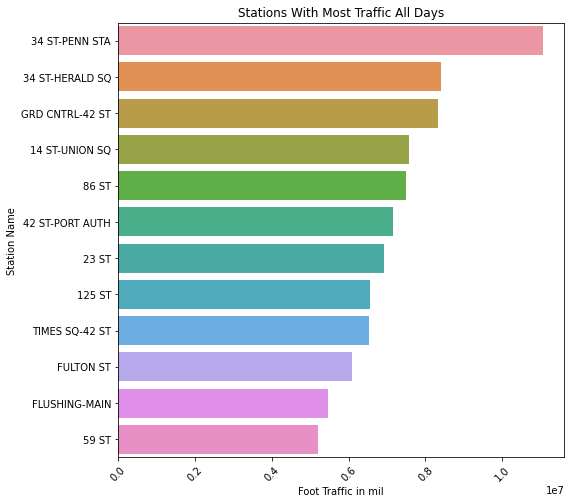

In [75]:
plt.figure(figsize=(8,8))
sns.barplot(x=by_station['All_Differences'][:12], y=by_station['Station'][:12] )
plt.title('Stations With Most Traffic All Days')
plt.xlabel('Foot Traffic in mil')
plt.ylabel('Station Name')
plt.xticks(rotation=45);

## By Hour Totals WeekDays

In [87]:
by_hour = by_groups.groupby(['Hour'])[['Entries_Diff', 'Exits_Diff','All_Differences']].sum().sort_values('All_Differences', ascending=False)\
    .reset_index()

by_hour.sort_values('Hour', inplace=True)
by_hour.head()

,Hour,Entries_Diff,Exits_Diff,All_Differences
8,0,11090749.0,16289711.0,27380460.0
9,1,5315797.0,8099210.0,13415007.0
20,2,457791.0,475281.0,933072.0
23,3,109842.0,143314.0,253156.0
10,4,2012861.0,4156015.0,6168876.0


''

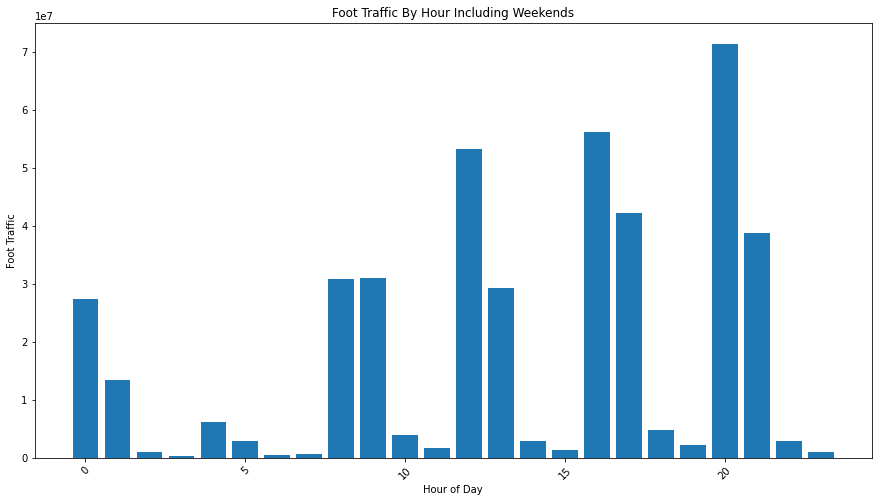

In [192]:
#By Hour of Day
plt.figure(figsize = (15,8))
plt.bar(by_hour['Hour'], by_hour['All_Differences'])

plt.title('Foot Traffic By Hour Including Weekends')
plt.ylabel('Foot Traffic')
plt.xlabel('Hour of Day')
plt.xticks(rotation=45)
plt.savefig("./graphs/All_Days_hours_agg_footTraffic")
;

## By Day Totals ALL DAYS

In [185]:
by_day = by_groups.groupby(['Day', 'Day#'])[['Entries_Diff', 'Exits_Diff','All_Differences']].sum().sort_values('All_Differences', ascending=False)\
    .reset_index()

by_day.sort_values('Day#', inplace=True)
by_day.head()

,Day,Day#,Entries_Diff,Exits_Diff,All_Differences
4,Mon,0,29493937.0,33086810.0,62580747.0
3,Tue,1,32057729.0,35802501.0,67860230.0
0,Wed,2,33246195.0,37086540.0,70332735.0
2,Thu,3,32493123.0,36455340.0,68948463.0
1,Fri,4,32870801.0,37152944.0,70023745.0


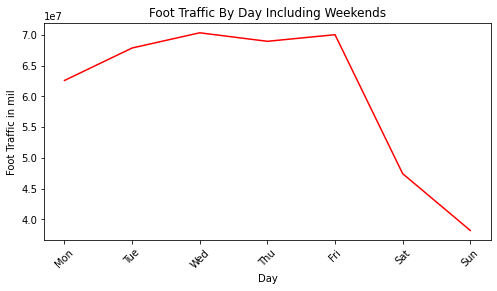

In [186]:
#By Day Name
plt.figure(figsize = (8,4))
plt.plot(by_day['Day'], by_day['All_Differences'], color='r')

plt.title('Foot Traffic By Day Including Weekends')
plt.ylabel('Foot Traffic in mil')
plt.xlabel('Day')

plt.xticks(rotation=45)
plt.savefig("./graphs/All_Days_footTraffic")
plt.show();

## Use only Weekdays - see plot above

In [66]:
noZerosNoNegatives.DayType.unique()

array(['WeekEnd', 'WeekDay'], dtype=object)

In [67]:
weekdays = noZerosNoNegatives[noZerosNoNegatives['DayType'] == 'WeekDay']
weekdays.shape

(1715565, 22)

In [68]:
weekdays.columns

Index(['index', 'C/A', 'Unit', 'Scp', 'Station', 'Linename', 'Division',
       'Date', 'Time', 'Desc', 'Entries', 'Exits', 'Turnstile', 'Station_loc',
       'DateNTime', 'Day', 'Day#', 'DayType', 'Hour', 'Entries_Diff',
       'Exits_Diff', 'All_Differences'],
      dtype='object')

## Using only WEEKDAYS Data, answer questions

In [69]:
#Group our data to see our resuls
weekdays_group = weekdays.groupby(["Station_loc", "Station","Turnstile","DateNTime","Date", "Hour","Day", "Day#"])[['Entries_Diff', 'Exits_Diff','All_Differences']].sum().reset_index()
weekdays_group.head()


,Station_loc,Station,Turnstile,DateNTime,Date,Hour,Day,Day#,Entries_Diff,Exits_Diff,All_Differences
0,1 AV L,1 AV,H007A|R248|02-00-00|1 AV,2021-08-02 00:00:00,08/02/2021,0,Mon,0,84.0,14.0,98.0
1,1 AV L,1 AV,H007A|R248|02-00-00|1 AV,2021-08-02 04:00:00,08/02/2021,4,Mon,0,8.0,6.0,14.0
2,1 AV L,1 AV,H007A|R248|02-00-00|1 AV,2021-08-02 08:00:00,08/02/2021,8,Mon,0,113.0,17.0,130.0
3,1 AV L,1 AV,H007A|R248|02-00-00|1 AV,2021-08-02 12:00:00,08/02/2021,12,Mon,0,246.0,16.0,262.0
4,1 AV L,1 AV,H007A|R248|02-00-00|1 AV,2021-08-02 16:00:00,08/02/2021,16,Mon,0,193.0,22.0,215.0


## By Station Totals Weekdays

In [72]:
by_station2 = weekdays_group.groupby('Station')[['Entries_Diff', 'Exits_Diff','All_Differences']].sum().sort_values('All_Differences', ascending=False)\
    .reset_index()[:20]

by_station.head(10)

,Station,Entries_Diff,Exits_Diff,All_Differences
0,34 ST-PENN STA,3731838.0,5010788.0,8742626.0
1,GRD CNTRL-42 ST,2823271.0,4078151.0,6901422.0
2,34 ST-HERALD SQ,2788100.0,3765514.0,6553614.0
3,86 ST,2605499.0,3424817.0,6030316.0
4,14 ST-UNION SQ,2423044.0,3435991.0,5859035.0
5,23 ST,2563392.0,3078789.0,5642181.0
6,42 ST-PORT AUTH,2533949.0,3101553.0,5635502.0
7,125 ST,2324230.0,2850114.0,5174344.0
8,FULTON ST,2160659.0,2813232.0,4973891.0
9,TIMES SQ-42 ST,2054237.0,2864921.0,4919158.0


''

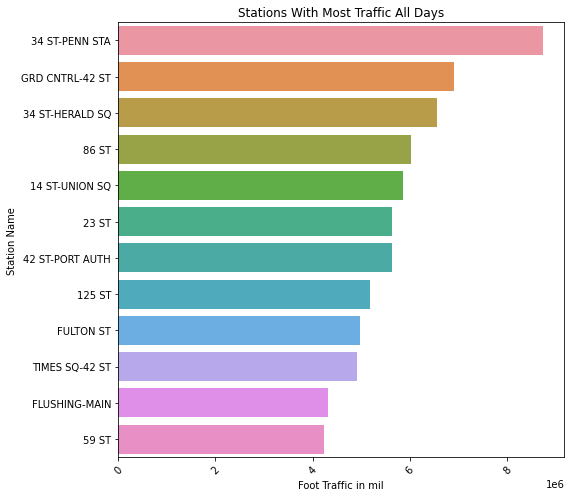

In [160]:
plt.figure(figsize=(8,8))
sns.barplot(x=by_station2['All_Differences'][:12], y=by_station2['Station'][:12] )
plt.title('Stations With Most Traffic All Days')
plt.xlabel('Foot Traffic in mil')
plt.ylabel('Station Name')
plt.xticks(rotation=45)
plt.savefig("./graphs/weekdays_footTraffic")
;

## By Day Totals WeekDays

In [82]:
by_day2 = weekdays_group.groupby(['Day', 'Day#'])[['Entries_Diff', 'Exits_Diff','All_Differences']].sum().sort_values('All_Differences', ascending=False)\
    .reset_index()

by_day2.sort_values('Day#', inplace=True)
by_day2.head()

,Day,Day#,Entries_Diff,Exits_Diff,All_Differences
4,Mon,0,29493937.0,33086810.0,62580747.0
3,Tue,1,32057729.0,35802501.0,67860230.0
0,Wed,2,33246195.0,37086540.0,70332735.0
2,Thu,3,32493123.0,36455340.0,68948463.0
1,Fri,4,32870801.0,37152944.0,70023745.0


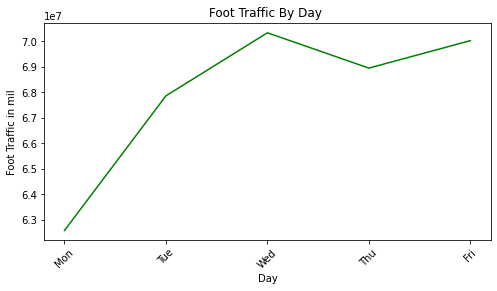

In [190]:
#By Day Name
plt.figure(figsize = (8,4))
plt.plot(by_day2['Day'], by_day2['All_Differences'], color='g')

plt.title('Foot Traffic By Day ')
plt.ylabel('Foot Traffic in mil')
plt.xlabel('Day')

plt.xticks(rotation=45)
plt.savefig("./graphs/M-F_footTraffic")
plt.show();

## By Hour Totals WeekDays

In [85]:
by_hour2 = weekdays_group.groupby(['Hour'])[['Entries_Diff', 'Exits_Diff','All_Differences']].sum().sort_values('All_Differences', ascending=False)\
    .reset_index()

by_hour2.sort_values('Hour', inplace=True)
by_hour2.head()

,Hour,Entries_Diff,Exits_Diff,All_Differences
8,0,7553659.0,10977563.0,18531222.0
9,1,3558080.0,5381771.0,8939851.0
20,2,284540.0,289715.0,574255.0
23,3,55472.0,75045.0,130517.0
11,4,1166308.0,2382420.0,3548728.0


''

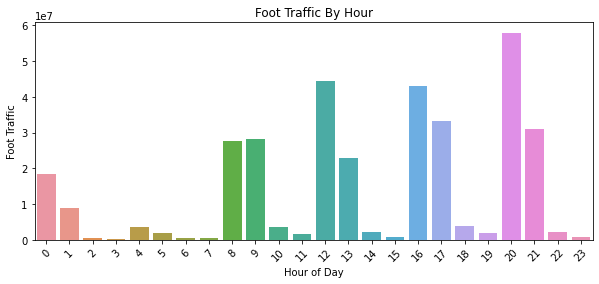

In [191]:
#By Hour of Day
plt.figure(figsize = (10,4))
sns.barplot(x=by_hour2['Hour'], y=by_hour2['All_Differences'])

plt.title('Foot Traffic By Hour')
plt.ylabel('Foot Traffic')
plt.xlabel('Hour of Day')
plt.xticks(rotation=45)
plt.savefig("./graphs/M-F-hourly_footTraffic")
;

## Start of AM Analysis

## AM == EXITS 
Weekdays AM hours will be used to look at Exits to find employees who we believe are arriving near or around their workplace

In [94]:
weekdays_am = weekdays[ (weekdays['Hour'] > 4) & (weekdays['Hour'] < 10) ]

In [95]:
sorted(weekdays_am.Hour.unique())

[5, 6, 7, 8, 9]

## AM By Hour Totals WeekDays

In [109]:
am_hour = weekdays_am.groupby('Hour')[['Entries_Diff', 'Exits_Diff','All_Differences']].sum().sort_values('Exits_Diff', ascending=False)\
    .reset_index()
am_hour

,Hour,Entries_Diff,Exits_Diff,All_Differences
0,9,14724340.0,13392211.0,28116551.0
1,8,15543808.0,12116549.0,27660357.0
2,5,734212.0,1008093.0,1742305.0
3,7,267687.0,278969.0,546656.0
4,6,203772.0,171466.0,375238.0


''

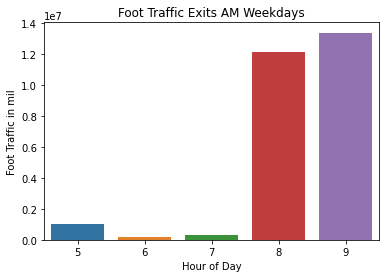

In [165]:
#By Hour of Day
plt.figure(figsize = (6,4))
sns.barplot(x=am_hour['Hour'], y=am_hour['Exits_Diff'])

plt.title('Foot Traffic Exits AM Weekdays')
plt.ylabel('Foot Traffic in mil')
plt.xlabel('Hour of Day')
plt.savefig("./graphs/AM-Hours_footTraffic")
;
#plt.xticks(rotation=40);

## AM By Day Totals WeekDays

In [112]:
am_day = weekdays_am.groupby(['Day#', 'Day'])[['Entries_Diff', 'Exits_Diff','All_Differences']].sum().sort_values('Exits_Diff', ascending=False)\
    .reset_index()
am_day.sort_values('Day#', inplace=True)
am_day

,Day#,Day,Entries_Diff,Exits_Diff,All_Differences
4,0,Mon,5877754.0,5049087.0,10926841.0
1,1,Tue,6415686.0,5529954.0,11945640.0
0,2,Wed,6673608.0,5690131.0,12363739.0
2,3,Thu,6382152.0,5428383.0,11810535.0
3,4,Fri,6124619.0,5269733.0,11394352.0


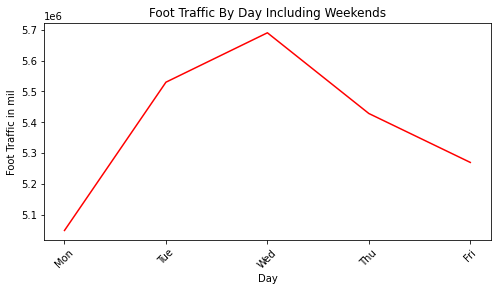

In [113]:
#By Day Name
plt.figure(figsize = (8,4))
plt.plot(am_day['Day'], am_day['Exits_Diff'], color='r')

plt.title('Foot Traffic By Day Including Weekends')
plt.ylabel('Foot Traffic in mil')
plt.xlabel('Day')

plt.xticks(rotation=45)
plt.show();

## AM By Station Totals WeekDays

In [114]:
am_station = weekdays_am.groupby('Station')[['Entries_Diff', 'Exits_Diff','All_Differences']].sum().sort_values('Exits_Diff', ascending=False)\
    .reset_index()
am_station.head()

,Station,Entries_Diff,Exits_Diff,All_Differences
0,GRD CNTRL-42 ST,312282.0,949245.0,1261527.0
1,14 ST-UNION SQ,192510.0,782470.0,974980.0
2,125 ST,418136.0,575539.0,993675.0
3,86 ST,340594.0,569303.0,909897.0
4,23 ST,159775.0,541136.0,700911.0


''

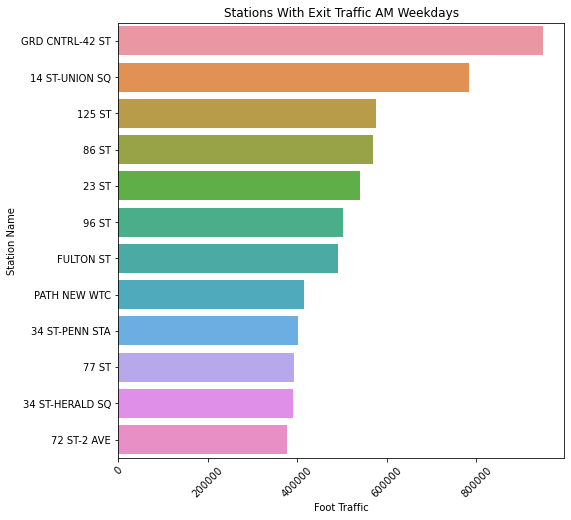

In [188]:
plt.figure(figsize=(8,8))
sns.barplot(x=am_station['Exits_Diff'][:12], y=am_station['Station'][:12] )
plt.title('Stations With Exit Traffic AM Weekdays')
plt.xlabel('Foot Traffic')
plt.ylabel('Station Name')
plt.xticks(rotation=45)
plt.savefig("./graphs/amStations_footTraffic")
;

## END OF AM VISUALIZATIONS

## Start of PM Analysis

## PM == ENTRIES 
Weekdays PM hours will be used to look at Entries to find employees who we believe are leaving their workplace

In [118]:
weekdays_pm =  weekdays[ (weekdays['Hour'] > 14) & (weekdays['Hour'] < 19) ]

In [119]:
sorted(weekdays_pm.Hour.unique())

[15, 16, 17, 18]

## PM By Hour Totals WeekDays

In [122]:
pm_hour = weekdays_pm.groupby('Hour')[['Entries_Diff', 'Exits_Diff','All_Differences']].sum().sort_values('Entries_Diff', ascending=False)\
    .reset_index()
pm_hour.sort_values('Entries_Diff', inplace=True)
pm_hour

,Hour,Entries_Diff,Exits_Diff,All_Differences
3,15,411070.0,472027.0,883097.0
2,18,1974315.0,1984996.0,3959311.0
1,17,16745436.0,16580249.0,33325685.0
0,16,21032302.0,21964863.0,42997165.0


''

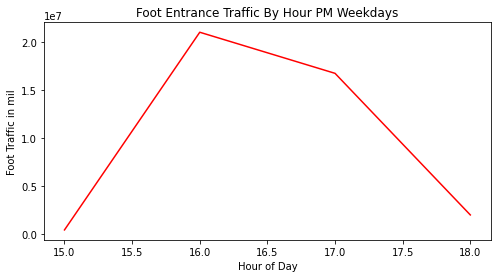

In [174]:
#By Hour of Day
pm_hour.sort_values('Hour', inplace=True)
plt.figure(figsize = (8,4))
#sns.barplot(x=pm_hour['Hour'], y=pm_hour['Entries_Diff'])
plt.plot(pm_hour['Hour'], pm_hour['Entries_Diff'], color='r')

plt.title('Foot Entrance Traffic By Hour PM Weekdays')
plt.ylabel('Foot Traffic in mil')
plt.xlabel('Hour of Day')
plt.savefig("./graphs/pmhrly_footTraffic")

;
#plt.xticks(rotation=40);

## PM By Day Totals WeekDays

In [126]:
pm_day = weekdays_pm.groupby(['Day#', 'Day'])[['Entries_Diff', 'Exits_Diff','All_Differences']].sum().sort_values('Entries_Diff', ascending=False)\
    .reset_index()
pm_day.sort_values('Day#', inplace=True)
pm_day

,Day#,Day,Entries_Diff,Exits_Diff,All_Differences
4,0,Mon,7518405.0,7703510.0,15221915.0
3,1,Tue,7877602.0,7979844.0,15857446.0
1,2,Wed,8189196.0,8311930.0,16501126.0
2,3,Thu,7958452.0,8096847.0,16055299.0
0,4,Fri,8619468.0,8910004.0,17529472.0


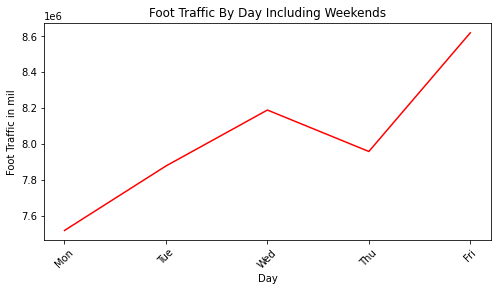

In [127]:
#By Day Name
plt.figure(figsize = (8,4))
plt.plot(pm_day['Day'], pm_day['Entries_Diff'], color='r')

plt.title('Foot Traffic By Day Including Weekends')
plt.ylabel('Foot Traffic in mil')
plt.xlabel('Day')

plt.xticks(rotation=45)
plt.show();

## PM By Station Totals WeekDays

In [128]:
pm_station = weekdays_pm.groupby('Station')[['Entries_Diff', 'Exits_Diff','All_Differences']].sum().sort_values('Entries_Diff', ascending=False)\
    .reset_index()
pm_station.head()

,Station,Entries_Diff,Exits_Diff,All_Differences
0,14 ST-UNION SQ,826265.0,854183.0,1680448.0
1,23 ST,789002.0,719229.0,1508231.0
2,34 ST-PENN STA,785173.0,1406178.0,2191351.0
3,GRD CNTRL-42 ST,735193.0,853610.0,1588803.0
4,86 ST,713879.0,766570.0,1480449.0


''

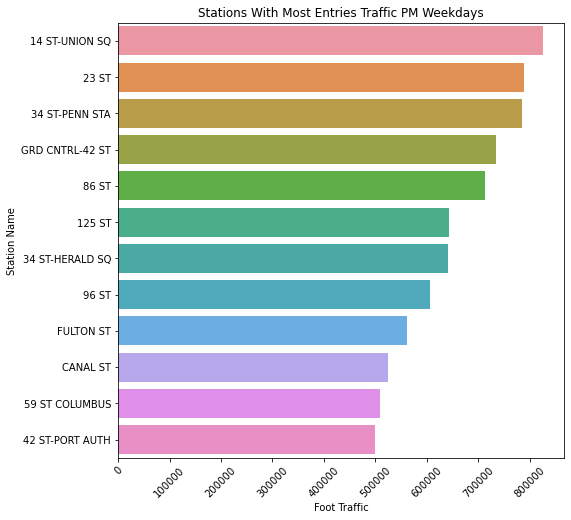

In [167]:
plt.figure(figsize=(8,8))
sns.barplot(x=pm_station['Entries_Diff'][:12], y=pm_station['Station'][:12] )

plt.title('Stations With Most Entries Traffic PM Weekdays')
plt.xlabel('Foot Traffic')
plt.ylabel('Station Name')
plt.xticks(rotation=45)
plt.savefig("./graphs/pmStations_footTraffic")
;

## END OF AM VISUALIZATIONS

## Start of NOON Analysis

## NOON == Entries + Exits
noon hours will be used to look at Entries and Exits to find employees as well as others roaming the streets

In [133]:
weekdays_noon = weekdays[ (weekdays['Hour'] > 10) & (weekdays['Hour'] < 15) ]

In [134]:
sorted(weekdays_noon.Hour.unique())

[11, 12, 13, 14]

## Noon By Hour Totals WeekDays

In [135]:
noon_hour = weekdays_noon.groupby('Hour')[['Entries_Diff', 'Exits_Diff','All_Differences']].sum().sort_values('All_Differences', ascending=False)\
    .reset_index()
noon_hour.sort_values('Entries_Diff', inplace=True)
noon_hour

,Hour,Entries_Diff,Exits_Diff,All_Differences
3,11,596323.0,925254.0,1521577.0
2,14,965088.0,1176829.0,2141917.0
1,13,10311398.0,12636338.0,22947736.0
0,12,19850032.0,24592151.0,44442183.0


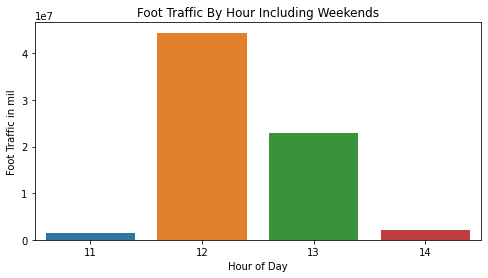

In [136]:
#By Hour of Day
plt.figure(figsize = (8,4))
sns.barplot(x=noon_hour['Hour'], y=noon_hour['All_Differences'])

plt.title('Foot Traffic By Hour Including Weekends')
plt.ylabel('Foot Traffic in mil')
plt.xlabel('Hour of Day');
#plt.xticks(rotation=40);

## Noon By Day Totals WeekDays

In [137]:
noon_day = weekdays_noon.groupby(['Day#', 'Day'])[['Entries_Diff', 'Exits_Diff','All_Differences']].sum().sort_values('All_Differences', ascending=False)\
    .reset_index()
noon_day.sort_values('Day#', inplace=True)
noon_day

,Day#,Day,Entries_Diff,Exits_Diff,All_Differences
4,0,Mon,5938758.0,7359865.0,13298623.0
2,1,Tue,6407053.0,8006910.0,14413963.0
0,2,Wed,6638429.0,8231625.0,14870054.0
1,3,Thu,6412502.0,8006661.0,14419163.0
3,4,Fri,6326099.0,7725511.0,14051610.0


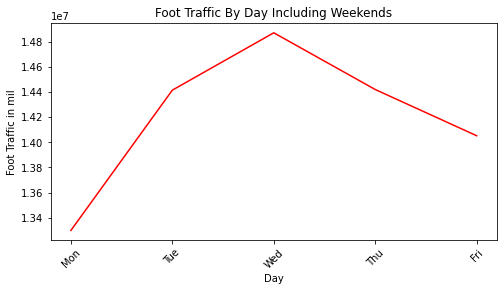

In [138]:
#By Day Name
plt.figure(figsize = (8,4))
plt.plot(noon_day['Day'], noon_day['All_Differences'], color='r')

plt.title('Foot Traffic By Day Including Weekends')
plt.ylabel('Foot Traffic in mil')
plt.xlabel('Day')

plt.xticks(rotation=45)
plt.show();

## Noon By Station Totals WeekDays

In [139]:
noon_station = weekdays_noon.groupby('Station')[['Entries_Diff', 'Exits_Diff','All_Differences']].sum().sort_values('All_Differences', ascending=False)\
    .reset_index()
noon_station.head()

,Station,Entries_Diff,Exits_Diff,All_Differences
0,34 ST-PENN STA,802603.0,995512.0,1798115.0
1,GRD CNTRL-42 ST,521510.0,1129022.0,1650532.0
2,34 ST-HERALD SQ,449099.0,1097525.0,1546624.0
3,86 ST,501464.0,875932.0,1377396.0
4,23 ST,394213.0,926679.0,1320892.0


''

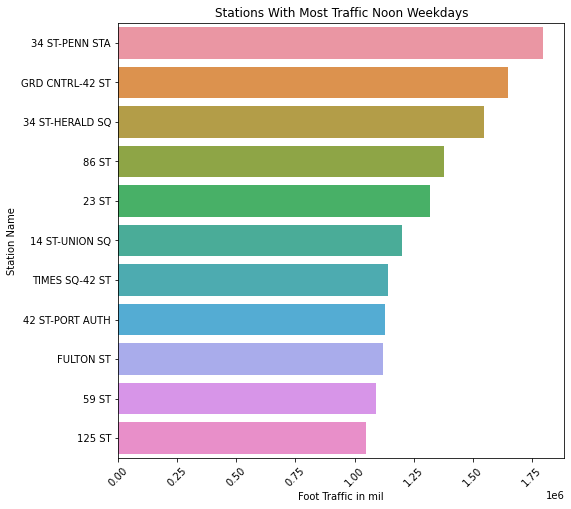

In [183]:
plt.figure(figsize=(8,8))
sns.barplot(x=noon_station['All_Differences'][:11], y=noon_station['Station'][:11] )

plt.title('Stations With Most Traffic Noon Weekdays')
plt.xlabel('Foot Traffic in mil')
plt.ylabel('Station Name')
plt.xticks(rotation=45)
plt.savefig("./graphs/noonStations_footTraffic")
;

## END OF Noon VISUALIZATIONS